In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp
from collections import deque

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 11:30:34.506355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)#, torch_dtype=torch.float16)
device = "cuda"
pipe = pipe.to(device)
pipe.safety_checker = None

HfHubHTTPError: 502 Server Error: Bad Gateway for url: https://huggingface.co/api/models/stabilityai/stable-diffusion-2-base

In [3]:
# Settings
prompt = ["beautiful tree"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device="cuda")
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [4]:
latent = denoise([1], 0, config, return_all_samples=False, generator=generator)

100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


In [67]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

NameError: name 'latent' is not defined

Particles

In [4]:
path = "model16.pt"
net = CNN16()
save_weights = False

if save_weights:
    # Initialise weights
    net.apply(init_weights)
    # Store weights and model
    torch.save(net.state_dict(), path)

# Load model instead of re-initialising
net.load_state_dict(torch.load(path))
net.to(torch.device("cuda"))

CNN16(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (act): ReLU()
)

In [26]:
def repulsive_step(
        particles,
        scores,
        phi_history,
        model,
        K,
        generator,
        add_noise = True,
        step_size=0.2,
        repulsive_scale=1000.0, # strength of repulsive term
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            scores: list of scores for each latent sample
            phi_history: List of previous phi particles used
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        grads = []
        for particle in particles:
            # Embed latent to smaller dimension
            phi = model(particle)
            phi_history.append(phi)

            # Compute gradient ∇_latent (phi) for pushforward gradient computation
            grad = torch.autograd.functional.jacobian(
                model, 
                particle.clone().detach().requires_grad_()
            )
            grads.append(grad)

        # Compute kernel gradients
        tphis = torch.stack(list(phi_history),axis=0)
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(tphis, tphis)
        # print(f"Sigma: {K.sigma.item()}")
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(tphis, tphis)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term
        nparticles = len(particles)
        new_particles = []
        for i in range(nparticles):
            # Pushforward/Chain rule
            # TODO: Check this multiplication is right
            repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,i], grads[i]) / nparticles

            # (debug) Get repulsion norm
            # repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
            # print(repulsive_norm.item())

            # (debug) Save repulsion term
            # torch.save(repulsive, f'repulsive{i}.pt')

            # Score + Repulsion
            new_particle = particles[i] + step_size * (scores[i] + repulsive_scale * repulsive)
            # ONLY Repulsion
            # new_particle = particles[i] + step_size * (repulsive_scale * repulsive)
            if add_noise:
                noise = torch.randn(particles[i].shape, layout=particles[i].layout, device=device, generator=generator).to(device)
                new_particle += ((step_size * 2) ** 0.5) * noise

            new_particles.append(new_particle)
        return new_particles

In [6]:
def compare_particles(init_particles, particles, model):
    # L2 distance between initial and evolved particles in SD2 latent space and model embedding latent space
    n = len(init_particles)
    sd_diff = 0
    emb_diff = 0
    for i in range(n):
        sd_diff += torch.mean((init_particles[i]-particles[i])**2)
        emb_diff += torch.mean((model(init_particles[i]) - model(particles[i]))**2)
    
    sd_diff/=n
    emb_diff/=n
    print(f"SD2 L2 distance: {sd_diff}")
    print(f"Embedding L2 distance: {emb_diff}")

def spread(particles):
    # Get L2 distances between particles
    spread=0
    n = len(particles)
    for i in range(n):
        for j in range(i+1,n):
            spread += torch.mean((particles[i]-particles[j])**2)
    
    return spread

In [7]:
# Particle diffusion
def correct_particles(
    particles,
    sigma,
    t,
    correction_steps,
    correction_method,
    config,
    generator,
    step_size=0.2,
    model=None,
    K=None,
    phi_history_size=20
    ):
    """ At certain noise scale (step t), apply correction steps to all particles
        particles: N particles in the diffusion process
        method (str): type of correction step "random", "langevin", "score", or "repulsive"
        model: Embedding model (must be defined if repulsive correct_type specified)
        K: RBF Kernel (must be defined if repulsive correct_type specified)
        TODO: Make sampler factory class
    """
    if correction_method=="random":
        new_particles = random_step(particles, correction_steps, generator, step_size=step_size)
    elif correction_method=="repulsive":
        # Parallel particles
        phi_history = deque([], phi_history_size)
        for i in range(correction_steps):
            scores = [get_score(particle, sigma, t, config) for particle in particles]
            particles = repulsive_step(particles, scores, phi_history, model, K, generator, step_size=step_size)
            print(f"Correction {i} spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        new_particles = particles
    elif correction_method=="repulsive_series":
        # TODO Particles in series
        new_particles = []
    elif correction_method=="langevin" or correction_method=="score":
        new_particles = []
        add_noise = (correction_method=="langevin")
        for particle in particles:
            for _ in range(correction_steps):
                score = get_score(particle, sigma, t, config)
                particle = langevin_step(particle, score, generator, step_size=step_size, add_noise=add_noise)
            new_particles.append(particle)
    else:
        print(f"ERROR: Correction step type: '{correction_method}' not implemented yet")
            
    return new_particles

def denoise_particles(
    config,
    generator,
    correction_levels=[],
    correction_steps=1,
    correction_step_size=0.2,
    correction_method="langevin",
    addpart_level=0,
    addpart_steps=1,
    addpart_step_size=0.2,
    addpart_method="langevin",
    num_particles=1,
    Model=CNN16,
    model_path=path,
    Kernel=RBF,
    device="cuda",
):
    """ General function to take steps and add particles at different noise levels of diffusion
        correction_levels (int or List[int]): noise level indices to do correction steps in
        correction_steps (int or List[int]): number of correction steps to take in each noise level
        correction_method (str or List[str]): method of correction e.g. random, langevin, score 
        addpart_level (int): noise level index to add particles in
        addpart_steps (int): number of steps taken between particles
        addpart_method (str): method of steps for adding particles e.g. random, langevin, score (NOT repulsive)
        config (Dict): info for diffusion
        generator: RNG generator - reset before calling this method
        num_particles=2: number of particles to add at addpart_level
        Model: Embedding model for repulsion
        model_path: path to embedding model weights
        Kernel=RBF: Kernel class to use for repulsive steps
        device="cuda",
    """
    if addpart_method=="repulsive":
        print("Cannot use repulsive steps to add new particles.")
        return None
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']
    latents = config['init_latents'] * sigmas.max()

    # Embedding model for repulsive force
    model = Model()
    model.load_state_dict(torch.load(model_path))
    model.to(torch.device("cuda"))

    # Kernel
    K = Kernel()

    particles = [latents]
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]

        # Create particles
        if i==addpart_level:
            for _ in range(num_particles-1):
                new_particle = correct_particles(
                    [particles[-1]], 
                    sigma, 
                    t, 
                    correction_steps=addpart_steps, 
                    correction_method=addpart_method, 
                    config=config, 
                    generator=generator, 
                    step_size=addpart_step_size, 
                    model=model, 
                    K=K
                )
                particles.append(new_particle[0])
            print(f"Initial spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        
        # Correction steps
        if i in correction_levels:
            particles = correct_particles(
                particles, 
                sigma, 
                t, 
                correction_steps, 
                correction_method=correction_method, 
                config=config, 
                generator=generator, 
                step_size=correction_step_size, 
                model=model, 
                K=K
            )
        
        # Move to next marginal in diffusion
        for n in range(len(particles)):
            score = get_score(particles[n], sigma, t, config)
            particles[n] = step_score(particles[n], score, sigmas, step_index)
    
    return particles

In [27]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
particles = denoise_particles(config, generator, num_particles=5, correction_levels=[0,1,2,3,4,5,6,7,8], correction_steps=20, correction_step_size=0.1, correction_method="repulsive")

  0%|          | 0/20 [00:00<?, ?it/s]

Initial spread: SD - 7.759521484375 embedding - 0.00013357822899706662
Correction 0 spread: SD - 11.958355903625488 embedding - 0.009819453582167625
Correction 1 spread: SD - 16.052379608154297 embedding - 0.014692901633679867
Correction 2 spread: SD - 20.144338607788086 embedding - 0.019542157649993896
Correction 3 spread: SD - 24.24869155883789 embedding - 0.02272193133831024
Correction 4 spread: SD - 28.18575668334961 embedding - 0.022785089910030365
Correction 5 spread: SD - 32.1043586730957 embedding - 0.022760266438126564
Correction 6 spread: SD - 36.08995056152344 embedding - 0.021253658458590508
Correction 7 spread: SD - 39.99590301513672 embedding - 0.021860240027308464
Correction 8 spread: SD - 44.138023376464844 embedding - 0.022709036245942116
Correction 9 spread: SD - 47.971466064453125 embedding - 0.022754015401005745
Correction 10 spread: SD - 51.949562072753906 embedding - 0.02186809852719307
Correction 11 spread: SD - 55.962921142578125 embedding - 0.02159225568175316


  5%|▌         | 1/20 [00:50<16:08, 51.00s/it]

Correction 0 spread: SD - 51.16083526611328 embedding - 0.005475771613419056
Correction 1 spread: SD - 54.86080551147461 embedding - 0.0029411762952804565
Correction 2 spread: SD - 58.876365661621094 embedding - 0.001503291423432529
Correction 3 spread: SD - 62.85608673095703 embedding - 0.0032998244278132915
Correction 4 spread: SD - 67.03794860839844 embedding - 0.008331917226314545
Correction 5 spread: SD - 71.3694076538086 embedding - 0.017938736826181412
Correction 6 spread: SD - 75.47940063476562 embedding - 0.025808827951550484
Correction 7 spread: SD - 79.335693359375 embedding - 0.023293374106287956
Correction 8 spread: SD - 83.21607971191406 embedding - 0.022341668605804443
Correction 9 spread: SD - 87.13955688476562 embedding - 0.02177172526717186
Correction 10 spread: SD - 90.9497299194336 embedding - 0.01888146437704563
Correction 11 spread: SD - 94.63597869873047 embedding - 0.017109284177422523
Correction 12 spread: SD - 98.44570922851562 embedding - 0.01730518974363804


 10%|█         | 2/20 [01:41<15:08, 50.48s/it]

Correction 0 spread: SD - 75.13631439208984 embedding - 0.021320275962352753
Correction 1 spread: SD - 78.94819641113281 embedding - 0.018642965704202652
Correction 2 spread: SD - 82.56108093261719 embedding - 0.015827342867851257
Correction 3 spread: SD - 86.54672241210938 embedding - 0.01789999008178711
Correction 4 spread: SD - 90.40979766845703 embedding - 0.019083702936768532
Correction 5 spread: SD - 94.13239288330078 embedding - 0.017223991453647614
Correction 6 spread: SD - 97.8635482788086 embedding - 0.01621197536587715
Correction 7 spread: SD - 101.57400512695312 embedding - 0.01697830855846405
Correction 8 spread: SD - 105.26605224609375 embedding - 0.015724439173936844
Correction 9 spread: SD - 108.87236022949219 embedding - 0.014267455786466599
Correction 10 spread: SD - 112.4440689086914 embedding - 0.013543916866183281
Correction 11 spread: SD - 115.93232727050781 embedding - 0.01264643669128418
Correction 12 spread: SD - 119.50628662109375 embedding - 0.011544409207999

 15%|█▌        | 3/20 [02:31<14:15, 50.31s/it]

Correction 0 spread: SD - 90.07528686523438 embedding - 0.007463335990905762
Correction 1 spread: SD - 93.47844696044922 embedding - 0.0037133689038455486
Correction 2 spread: SD - 96.91372680664062 embedding - 0.0021470175124704838
Correction 3 spread: SD - 100.26161193847656 embedding - 0.005237044766545296
Correction 4 spread: SD - 103.88618469238281 embedding - 0.013003140687942505
Correction 5 spread: SD - 107.68819427490234 embedding - 0.0242297500371933
Correction 6 spread: SD - 111.31352996826172 embedding - 0.025668591260910034
Correction 7 spread: SD - 115.02855682373047 embedding - 0.02385779470205307
Correction 8 spread: SD - 118.35604858398438 embedding - 0.025040514767169952
Correction 9 spread: SD - 121.6451644897461 embedding - 0.022956497967243195
Correction 10 spread: SD - 125.03755187988281 embedding - 0.02105511538684368
Correction 11 spread: SD - 128.33615112304688 embedding - 0.02032075636088848
Correction 12 spread: SD - 131.73582458496094 embedding - 0.018349420

 20%|██        | 4/20 [03:21<13:24, 50.26s/it]

Correction 0 spread: SD - 98.74752044677734 embedding - 0.009235166944563389
Correction 1 spread: SD - 101.71541595458984 embedding - 0.004844117444008589
Correction 2 spread: SD - 104.99773406982422 embedding - 0.0038906873669475317
Correction 3 spread: SD - 108.38481903076172 embedding - 0.009731119498610497
Correction 4 spread: SD - 111.79692840576172 embedding - 0.020420413464307785
Correction 5 spread: SD - 114.98773193359375 embedding - 0.02664531022310257
Correction 6 spread: SD - 118.04039001464844 embedding - 0.025035733357071877
Correction 7 spread: SD - 120.94938659667969 embedding - 0.025751017034053802
Correction 8 spread: SD - 123.94125366210938 embedding - 0.02578781545162201
Correction 9 spread: SD - 126.60946655273438 embedding - 0.02129020169377327
Correction 10 spread: SD - 129.6526641845703 embedding - 0.01927471160888672
Correction 11 spread: SD - 132.66510009765625 embedding - 0.01604653149843216
Correction 12 spread: SD - 135.28932189941406 embedding - 0.01058537

 25%|██▌       | 5/20 [04:11<12:32, 50.18s/it]

Correction 0 spread: SD - 102.94615173339844 embedding - 0.006886846851557493
Correction 1 spread: SD - 105.5708999633789 embedding - 0.0036923231091350317
Correction 2 spread: SD - 108.34318542480469 embedding - 0.0030762399546802044
Correction 3 spread: SD - 111.0950698852539 embedding - 0.007584472186863422
Correction 4 spread: SD - 113.88854217529297 embedding - 0.01392389927059412
Correction 5 spread: SD - 116.56112670898438 embedding - 0.016576193273067474
Correction 6 spread: SD - 119.1672134399414 embedding - 0.01809038408100605
Correction 7 spread: SD - 121.84471130371094 embedding - 0.018537485972046852
Correction 8 spread: SD - 124.35311889648438 embedding - 0.017576562240719795
Correction 9 spread: SD - 126.78378295898438 embedding - 0.016624722629785538
Correction 10 spread: SD - 129.4241180419922 embedding - 0.015947625041007996
Correction 11 spread: SD - 131.71604919433594 embedding - 0.01600012183189392
Correction 12 spread: SD - 134.01913452148438 embedding - 0.0142168

 30%|███       | 6/20 [05:01<11:42, 50.20s/it]

Correction 0 spread: SD - 101.79653930664062 embedding - 0.006879463326185942
Correction 1 spread: SD - 103.67017364501953 embedding - 0.004394072107970715
Correction 2 spread: SD - 105.7430419921875 embedding - 0.005373937077820301
Correction 3 spread: SD - 107.58512115478516 embedding - 0.010426892898976803
Correction 4 spread: SD - 109.53720092773438 embedding - 0.0168265663087368
Correction 5 spread: SD - 111.35281372070312 embedding - 0.01845807395875454
Correction 6 spread: SD - 113.28155517578125 embedding - 0.015363962389528751
Correction 7 spread: SD - 115.52133178710938 embedding - 0.013801224529743195
Correction 8 spread: SD - 117.31561279296875 embedding - 0.011985991150140762
Correction 9 spread: SD - 118.78697204589844 embedding - 0.010297509841620922
Correction 10 spread: SD - 120.55120849609375 embedding - 0.010815209709107876
Correction 11 spread: SD - 122.71390533447266 embedding - 0.011775314807891846
Correction 12 spread: SD - 124.80475616455078 embedding - 0.012588

 35%|███▌      | 7/20 [05:51<10:52, 50.18s/it]

Correction 0 spread: SD - 93.97216796875 embedding - 0.003867550753057003
Correction 1 spread: SD - 95.25782775878906 embedding - 0.0015362080885097384
Correction 2 spread: SD - 96.59507751464844 embedding - 0.0034630701411515474
Correction 3 spread: SD - 97.93875122070312 embedding - 0.007882216945290565
Correction 4 spread: SD - 99.27217102050781 embedding - 0.015234739519655704


 35%|███▌      | 7/20 [06:07<11:21, 52.46s/it]

Correction 5 spread: SD - 100.50379943847656 embedding - 0.015854930505156517


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB (GPU 0; 10.76 GiB total capacity; 7.98 GiB already allocated; 642.56 MiB free; 8.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

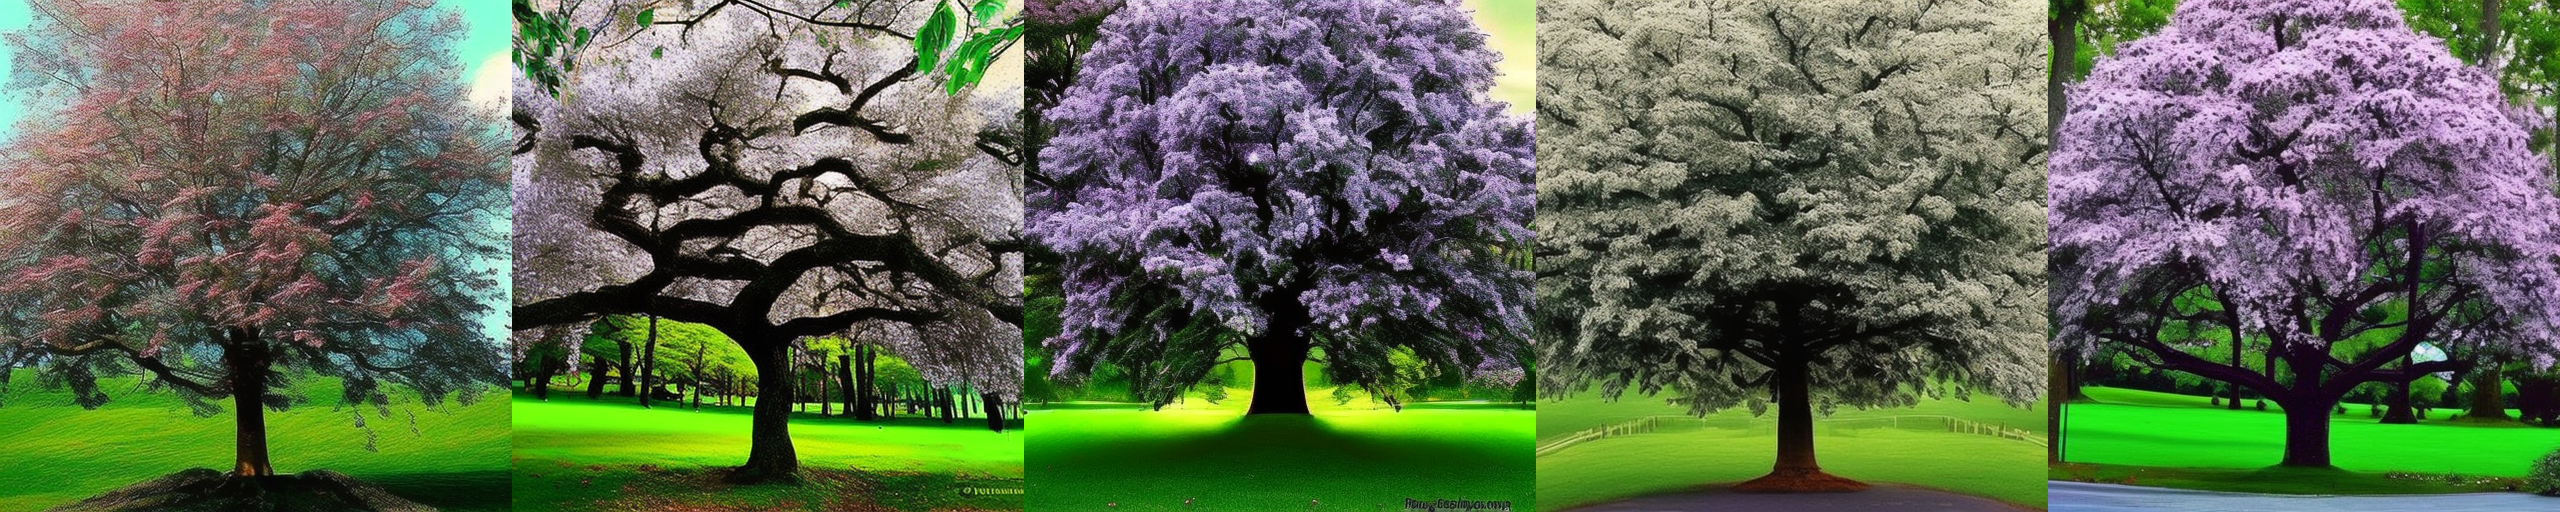

In [25]:
# Plot image results
# Plot list of decoded latents
visualise_latent_list = particles

pil_images = []
for l in visualise_latent_list:
    image = output_to_img(decode_latent(l, pipe.vae))
    images = (image * 255).round().astype("uint8")
    pil_images.append([Image.fromarray(image) for image in images][0])

grid = image_grid(pil_images,1,len(visualise_latent_list))
grid

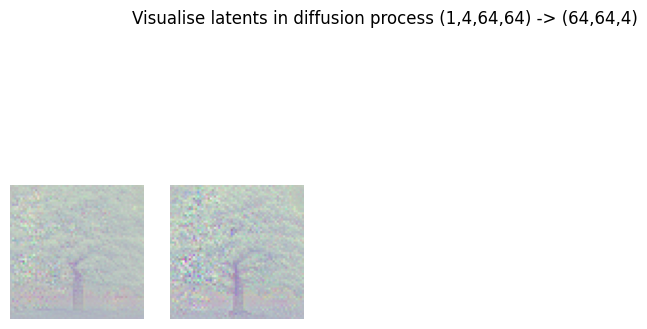

In [28]:
visualise_latent_list = particles

import matplotlib.pyplot as plt
lats = latent_to_img(visualise_latent_list)
plt.figure(figsize=(10,5))
plt.suptitle("Visualise latents in diffusion process (1,4,64,64) -> (64,64,4)")
for i, lat in enumerate(lats):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(lat)

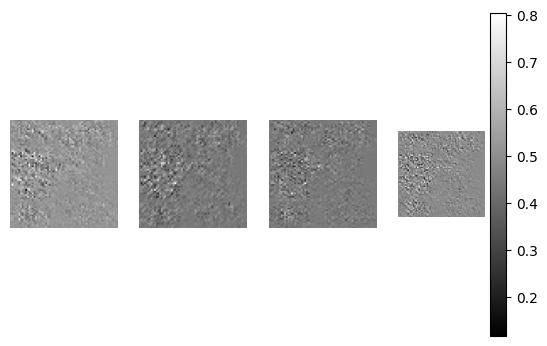

In [51]:
# Plot repulsive term
repulsive = torch.load('repulsive3.pt')
lat = latent_to_img([repulsive])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(lat[0][...,i], cmap='gray')
plt.colorbar()

In [33]:
repulsive

tensor([[[[ 9.2832e-04,  4.5789e-03,  2.6533e-04,  ..., -2.9138e-03,
            3.6366e-04,  1.9170e-03],
          [-1.8788e-04,  2.7751e-03, -2.7535e-03,  ...,  3.3567e-03,
           -6.2588e-03,  6.5956e-03],
          [ 4.3384e-04, -7.9534e-04,  3.2360e-03,  ..., -1.6692e-03,
            1.2745e-04,  6.0662e-03],
          ...,
          [ 3.4474e-05, -5.3542e-03,  5.6124e-04,  ..., -9.0950e-03,
           -1.5915e-03, -5.8526e-05],
          [-7.8929e-04, -4.0249e-03,  1.1507e-03,  ..., -1.2887e-04,
           -2.8203e-03, -2.2863e-03],
          [ 5.5013e-03, -1.7029e-03, -3.7889e-03,  ..., -3.0377e-03,
            1.7352e-03, -3.0281e-03]],

         [[ 1.0522e-03,  1.7171e-05, -1.4525e-03,  ..., -2.2544e-04,
            1.8536e-03,  1.7626e-03],
          [-1.3582e-03, -5.1985e-03,  1.9834e-03,  ..., -5.1391e-03,
            8.6768e-03,  2.2434e-03],
          [-9.7662e-04, -4.5187e-03,  9.0732e-04,  ...,  1.6637e-04,
            4.8782e-03,  1.4940e-03],
          ...,
     

In [20]:
lat[0].shape

torch.Size([64, 64, 4])

In [15]:
grid.save("experiments/test.png")

In [ ]:
# Plot repulsive norms
with open('out.txt') as f:
    lines = f.readlines()
norms = [float(line.split()[0]) for line in lines]
plt.plot(norms[::2], label="particle 1")
plt.plot(norms[1::2], label="particle 2")
plt.legend()
plt.ylabel("Repulsive term magnitude")
plt.xlabel("Steps")

In [14]:
import os, glob
for file in glob.glob("data/denoise_results/*/*/*"):
    new_file_name = file[:-25]+"0_stepseed"+file[-25:-6]+"_"+file[-5:]
    os.rename(file, new_file_name)

In [13]:
a = "data/denoise_results/langevin/a_black_cat/lvl12_seed4_nsteps100_stepsz0.1.png"
a[:-25]+"0_stepseed"+a[-25:-6]+"_"+a[-5:]

'data/denoise_results/langevin/a_black_cat/lvl12_seed0_stepseed4_nsteps100_stepsz0_1.png'

In [18]:
torch.mean((particles[1]-particles[2])**2) #0.2674

tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward0>)

Saving images

In [ ]:
import os, glob
import imageio.v3 as iio
for seed in range(2):
    for lvl in range(20):
        rows = []
        for file in glob.glob(f"data/denoise_results/langevin/a_black_cat_seed{seed}/lvl{lvl}*"):
            rows.append(iio.imread(file))
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(np.concatenate(rows, axis=0))
        name = f'langevin_seed{seed}_lvl{lvl}_nsteps100_stepsz0_1'
        plt.title(name)
        plt.savefig(f'data/denoise_results/langevin/collage/{name}.png')

In [15]:
os.path.basename(file)

'lvl0_seed0_stepseed13_nsteps100_stepsz0_1.png'

In [ ]:
# plot score
for seed in range(2):
    rows = []
    for file in glob.glob(f"data/denoise_results/score/a_black_cat_seed{seed}/*"):
        rows.append(iio.imread(file))
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(np.concatenate(rows, axis=0))
    name = f'score_seed{seed}_nsteps100_stepsz0_1'
    plt.title(name)
    plt.savefig(f'data/denoise_results/score/collage/{name}.png')